In [1]:
%load_ext autoreload
%autoreload 2

import torch

from propose.training.trainers import prior_trainer, flow_trainer
from propose.models.flows.glow import ConditionalGlow

from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

import torch.distributions as D

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class LabeledDataset(Dataset):
    def __init__(self, length=10):
        super().__init__()

        self.prior = D.mixture_same_family.MixtureSameFamily(
            D.Categorical(torch.ones(2)),
            D.MultivariateNormal(torch.Tensor([[0, 0, 10], [0, 0, -10]]), covariance_matrix=torch.stack((torch.eye(3), torch.eye(3))))
        )

        self.samples = self.prior.sample((length,))

    def __len__(self):
        return self.samples.__len__()

    def __getitem__(self, item):
        return self.samples[item, :2], self.samples[item]


class UnlabeledDataset(Dataset):
    def __init__(self, length=10):
        super().__init__()

        self.prior = D.mixture_same_family.MixtureSameFamily(
            D.Categorical(torch.ones(2)),
            D.MultivariateNormal(torch.Tensor([[0, 0, 10], [0, 0, -10]]), covariance_matrix=torch.stack((torch.eye(3), torch.eye(3))))
        )

        self.samples = self.prior.sample((length,))

    def __len__(self):
        return self.samples.__len__()

    def __getitem__(self, item):
        return self.samples[item, :2]

In [33]:
prior_flow = ConditionalGlow(context_features=0, num_layers=3, hidden_sizes=[10, 10, 10])

labeled_dataset = LabeledDataset(length=1000)
unlabeled_dataset = UnlabeledDataset(length=1000)

labeled_dataloader = DataLoader(labeled_dataset, batch_size=100)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=100)

In [41]:
prior_trainer(prior_flow, labeled_dataloader, epochs=200)

Epoch: 1/200 | NLLoss: 5.331 | Batch: 100%|██████████| 10/10 [00:00<00:00, 83.10it/s]
Epoch: 2/200 | NLLoss: 5.385 | Batch: 100%|██████████| 10/10 [00:00<00:00, 105.28it/s]
Epoch: 3/200 | NLLoss: 5.305 | Batch: 100%|██████████| 10/10 [00:00<00:00, 71.06it/s]
Epoch: 4/200 | NLLoss: 5.293 | Batch: 100%|██████████| 10/10 [00:00<00:00, 90.78it/s]
Epoch: 5/200 | NLLoss: 5.293 | Batch: 100%|██████████| 10/10 [00:00<00:00, 88.85it/s]
Epoch: 6/200 | NLLoss: 5.299 | Batch: 100%|██████████| 10/10 [00:00<00:00, 100.19it/s]
Epoch: 7/200 | NLLoss: 5.307 | Batch: 100%|██████████| 10/10 [00:00<00:00, 114.97it/s]
Epoch: 8/200 | NLLoss: 5.296 | Batch: 100%|██████████| 10/10 [00:00<00:00, 98.39it/s]
Epoch: 9/200 | NLLoss: 5.297 | Batch: 100%|██████████| 10/10 [00:00<00:00, 104.69it/s]
Epoch: 10/200 | NLLoss: 5.291 | Batch: 100%|██████████| 10/10 [00:00<00:00, 109.05it/s]
Epoch: 11/200 | NLLoss: 5.292 | Batch: 100%|██████████| 10/10 [00:00<00:00, 113.89it/s]
Epoch: 12/200 | NLLoss: 5.297 | Batch: 100%|██

In [42]:
z = prior_flow.sample(1000)
z = z.detach().numpy()

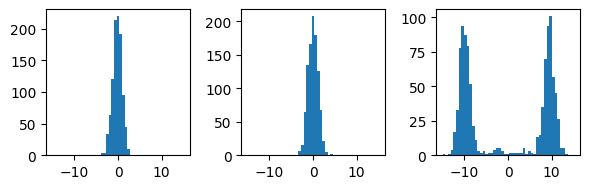

In [43]:
plt.style.use('default')
plt.figure(figsize=(6, 2))
plt.subplot(1, 3, 1)
plt.hist(z[..., 0], bins=np.linspace(-15, 15, 50))
plt.subplot(1, 3, 2)
plt.hist(z[..., 1], bins=np.linspace(-15, 15, 50))
plt.subplot(1, 3, 3)
plt.hist(z[..., 2], bins=np.linspace(-15, 15, 50))
plt.tight_layout()
plt.show()

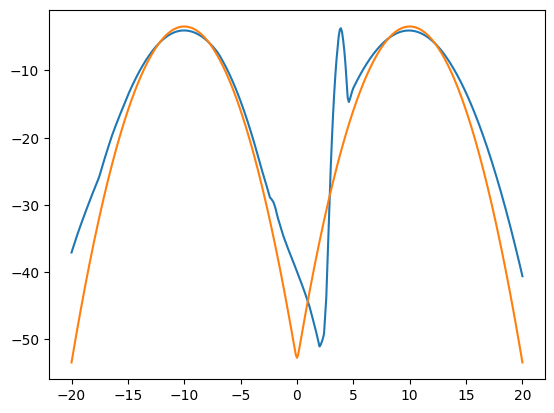

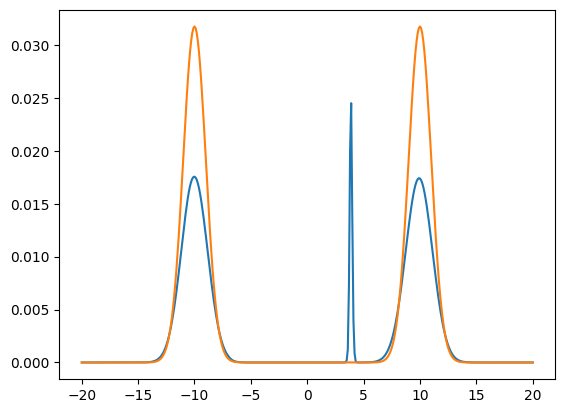

In [44]:
y = np.arange(-20, 20.1, 0.1)
x = np.zeros((len(y), 3))
x[..., -1] = y

log_prob_flow = prior_flow.log_prob(torch.Tensor(x)).detach()
log_prob_prior = labeled_dataset.prior.log_prob(torch.Tensor(x)).detach()

plt.plot(y, log_prob_flow)
plt.plot(y, log_prob_prior)
plt.show()

plt.plot(y, np.exp(log_prob_flow))
plt.plot(y, np.exp(log_prob_prior))
plt.show()

In [45]:
flow = ConditionalGlow(num_layers=3, hidden_sizes=[10, 10, 10])
labeled_dataloader = DataLoader(labeled_dataset, batch_size=10)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=10)

In [46]:
flow_trainer(flow, prior_flow, labeled_dataloader, unlabeled_dataloader, epochs=100)

Epoch: 1/100 | NLLoss: 20.14 | RecLoss: 1.133 | Batch: 100%|██████████| 100/100 [00:08<00:00, 12.26it/s]
Epoch: 2/100 | NLLoss: 24.99 | RecLoss: 0.27 | Batch: 100%|██████████| 100/100 [00:08<00:00, 12.37it/s] 
Epoch: 3/100 | NLLoss: 24.06 | RecLoss: 0.1128 | Batch: 100%|██████████| 100/100 [00:08<00:00, 12.43it/s]
Epoch: 4/100 | NLLoss: 23.24 | RecLoss: 0.064 | Batch: 100%|██████████| 100/100 [00:08<00:00, 12.42it/s] 
Epoch: 5/100 | NLLoss: 22.31 | RecLoss: 0.04255 | Batch: 100%|██████████| 100/100 [00:08<00:00, 12.41it/s]
Epoch: 6/100 | NLLoss: 21.82 | RecLoss: 0.03128 | Batch: 100%|██████████| 100/100 [00:08<00:00, 12.40it/s]
Epoch: 7/100 | NLLoss: 20.98 | RecLoss: 0.02439 | Batch: 100%|██████████| 100/100 [00:08<00:00, 12.40it/s]
Epoch: 8/100 | NLLoss: 20.37 | RecLoss: 0.0205 | Batch: 100%|██████████| 100/100 [00:08<00:00, 12.39it/s]
Epoch: 9/100 | NLLoss: 19.67 | RecLoss: 0.01661 | Batch: 100%|██████████| 100/100 [00:08<00:00, 12.33it/s]
Epoch: 10/100 | NLLoss: 19.47 | RecLoss: 0.0

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


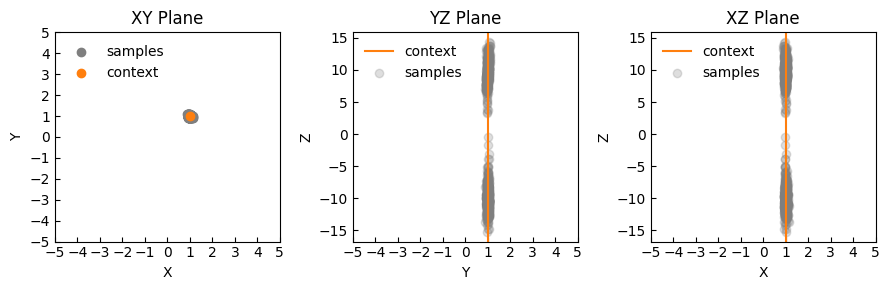

In [64]:
plt.style.use('default')

m = torch.Tensor([[1, 1]])
M, q_M_m = flow.sample_and_log_prob(1000, context=m)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.gca().tick_params(axis="both", direction="in")
plt.scatter(M[..., 0].detach(), M[..., 1].detach(), c='tab:gray', label='samples')
plt.scatter(m[..., 0], m[..., 1], c='tab:orange', label='context')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xticks(np.arange(-5, 6))
plt.yticks(np.arange(-5, 6))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('XY Plane')
plt.legend(frameon=False, loc='upper left')

plt.subplot(1, 3, 2)
plt.gca().tick_params(axis="both", direction="in")
plt.scatter(M[..., 1].detach(), M[..., 2].detach(), c='tab:gray', label='samples', alpha=0.25)
plt.axvline(m[..., 1], c='tab:orange', label='context')
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
plt.xticks(np.arange(-5, 6))
plt.yticks(np.arange(-15, 16, 5))
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('YZ Plane')
plt.legend(frameon=False, loc='upper left')

plt.subplot(1, 3, 3)
plt.gca().tick_params(axis="both", direction="in")
plt.scatter(M[..., 0].detach(), M[..., 2].detach(), c='tab:gray', label='samples', alpha=0.25)
plt.axvline(m[..., 0], c='tab:orange', label='context')
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
plt.xticks(np.arange(-5, 6))
plt.yticks(np.arange(-15, 16, 5))
plt.xlabel('X')
plt.ylabel('Z')
plt.title('XZ Plane')
plt.legend(frameon=False, loc='upper left')

plt.tight_layout()
plt.show()

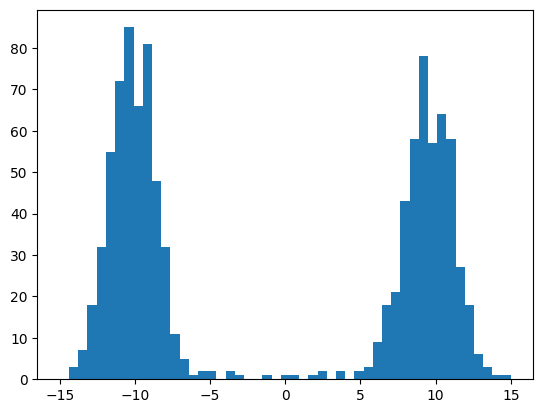

In [48]:
plt.hist(M[..., 2].detach(), bins=np.linspace(-15, 15, 50))
plt.show()


(0.5, 1.5)

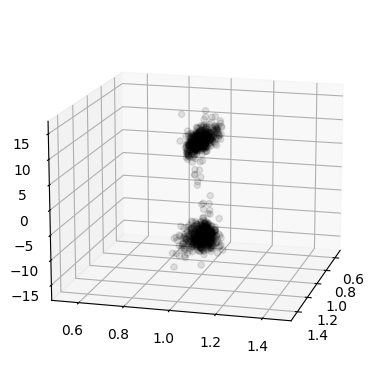

In [52]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

M_npy = M.detach().numpy()
ax.scatter(M_npy[..., 0], M_npy[..., 1], M_npy[..., 2], c='k', alpha=0.1)
ax.view_init(15, 15)
ax.set_xlim(0.5, 1.5)
ax.set_ylim(0.5, 1.5)